In [5]:
# 필요한 라이브러리 설치
!pip install torch torchvision torchaudio


In [6]:
# 라이브러리 임포트
import pandas as pd
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import TensorDataset, DataLoader, random_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Google Drive 마운트 (데이터 접근을 위해)
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
import re

In [8]:
from google.colab import drive
drive.mount('/content/drive')

# 데이터 경로 설정
base_path = '/content/drive/MyDrive/Graph LSTM/HDFS_v1/preprocessed/'

anomaly_label_path = base_path + 'anomaly_label.csv'
event_occurrence_matrix_path = base_path + 'Event_occurrence_matrix.csv'
log_templates_path = base_path + 'HDFS.log_templates.csv'
event_traces_path = base_path + 'Event_traces.csv'

# 데이터 로드
anomaly_label = pd.read_csv(anomaly_label_path)
event_occurrence_matrix = pd.read_csv(event_occurrence_matrix_path)
log_templates = pd.read_csv(log_templates_path)
event_traces = pd.read_csv(event_traces_path)

# 라벨 인코딩
label_dict = {'Normal': 0, 'Anomaly': 1}
anomaly_label['Label'] = anomaly_label['Label'].map(label_dict)

# 이벤트 ID 매핑 생성
event_id_to_template = dict(zip(log_templates['EventId'], log_templates['EventTemplate']))
event_ids = log_templates['EventId'].unique()
event_id_to_index = {event_id: idx for idx, event_id in enumerate(event_ids)}  # 이벤트 ID를 인덱스로 매핑

# 'BlockId'를 기준으로 데이터 병합
event_traces['BlockId'] = event_traces['BlockId'].astype(str)
anomaly_label['BlockId'] = anomaly_label['BlockId'].astype(str)
merged_data = pd.merge(event_traces, anomaly_label.rename(columns={'Label': 'AnomalyLabel'}), on='BlockId', how='inner')

# 'Features'를 이벤트 리스트로 변환
def parse_features(s):
    return re.findall(r'E\d+', s) if isinstance(s, str) else []

merged_data['Features'] = merged_data['Features'].apply(parse_features)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
# 입력 시퀀스 및 라벨 생성
inputs = []
labels = []
for _, row in merged_data.iterrows():
    # 이벤트 ID를 인덱스로 변환하여 입력 시퀀스로 사용
    event_indices = [event_id_to_index.get(event, 0) for event in row['Features']]
    if event_indices:  # 빈 시퀀스를 피하기 위해 확인
        inputs.append(event_indices)
        labels.append(row['AnomalyLabel'])

In [10]:
# PyTorch 텐서로 변환 (패딩을 사용해 시퀀스 길이 맞추기)
input_size = len(event_ids)  # 전체 이벤트 수를 특징 크기로 사용


In [11]:
# 입력 데이터를 패딩하여 고정된 길이의 시퀀스로 변환
inputs_tensor = torch.tensor([
    np.pad(seq, (0, max(0, input_size - len(seq))), 'constant')[:input_size] for seq in inputs
], dtype=torch.float32)
labels_tensor = torch.tensor(labels, dtype=torch.long)


<ipython-input-11-5481cef63e12>:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  inputs_tensor = torch.tensor([


In [12]:
# TensorDataset 생성 후 학습 및 테스트 데이터셋 분할
dataset = TensorDataset(inputs_tensor, labels_tensor)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])


In [13]:
# DataLoader 설정
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [27]:
# Dropout이 적용된 LSTM 모델 정의
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout=0.6):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        # LSTM 레이어에 Dropout 적용 (num_layers > 1일 때만 적용됨)
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, num_classes)
        # Fully Connected 레이어 전에 Dropout 추가
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # 초기 hidden 및 cell 상태 설정
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # LSTM 전방향 패스
        out, _ = self.lstm(x, (h0, c0))

        # Dropout 적용
        out = self.dropout(out)

        # 마지막 타임스텝의 출력값을 사용하여 분류
        out = self.fc(out[:, -1, :])
        return out


In [51]:
# 모델, 손실 함수, 최적화 함수 초기화
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
lstm_model = LSTMModel(input_size=input_size, hidden_size=128, num_layers=1, num_classes=2, dropout=0.6).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(lstm_model.parameters(), lr=0.00001)

# 학습 루프
num_epochs = 10
for epoch in range(num_epochs):
    lstm_model.train()
    total_loss = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = lstm_model(inputs.unsqueeze(1))
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss / len(train_loader):.4f}')


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
  warnings.warn(


Epoch [1/10], Loss: 0.1293
Epoch [2/10], Loss: 0.0652
Epoch [3/10], Loss: 0.0485
Epoch [4/10], Loss: 0.0379
Epoch [5/10], Loss: 0.0312
Epoch [6/10], Loss: 0.0269
Epoch [7/10], Loss: 0.0242
Epoch [8/10], Loss: 0.0219
Epoch [9/10], Loss: 0.0203
Epoch [10/10], Loss: 0.0188


In [52]:
# 모델 평가
lstm_model.eval()
correct = 0
total = 0
with torch.no_grad():
    for batch_inputs, batch_labels in test_loader:
        batch_inputs = batch_inputs.to(device)
        batch_labels = batch_labels.to(device)

        outputs = lstm_model(batch_inputs.unsqueeze(1))
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == batch_labels).sum().item()
        total += batch_labels.size(0)
accuracy = correct / total
print(f'LSTM Test Accuracy: {accuracy:.4f}')

LSTM Test Accuracy: 0.9955


Classification Report:
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00    111609
     Anomaly       0.97      0.87      0.92      3404

    accuracy                           1.00    115013
   macro avg       0.98      0.94      0.96    115013
weighted avg       1.00      1.00      1.00    115013



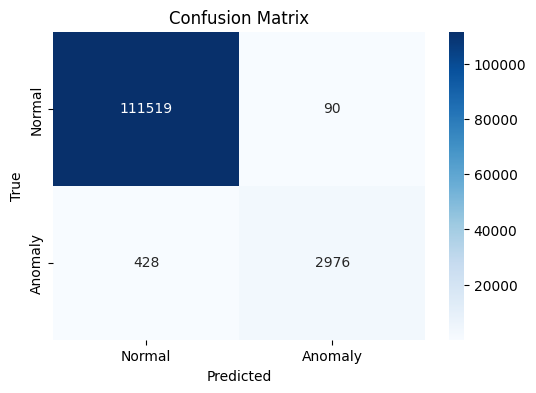

In [53]:
# 평가 및 성능 측정
lstm_model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = lstm_model(inputs.unsqueeze(1))
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Classification Report 출력
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=['Normal', 'Anomaly']))

# Confusion Matrix 시각화
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
